#  Unsupervised learning addition model with generator  -  using loopy encoder and decoder method

Author: S. Menary [sbmenary@gmail.com]

Date: 15/6/2023  (last update: 28/6/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

In this notebook, we implement transformer loops, idempotent mappings and extra configuration options such as encoder pre-loop layers (intended to govern representational shift).

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Remove tensorflow INFO messages
tf.get_logger().setLevel('WARNING')

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import AdamW
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_loopy_enc_dec_notebook_[global>problem_tag]_embed[model>ndim_embedding]_enc_[model>encoder>num_blocks]blocks_[model>encoder>num_loops]loops_width[model>encoder>ndim_ff_hidden]_dec_[model>decoder>num_blocks]blocks_[model>decoder>num_loops]loops_width[model>decoder>ndim_ff_hidden]_post[model>post_decoder>num_layers]_width[model>post_decoder>ndim]_idem[model>idempotent_size]_[date]",
        "problem_tag"      : "int1234_num1245",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 16,
            "num_batches"      : 1000,
            "gen_base_seed"    : 104,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [3, 6],
            "batch_size"       : 32,
            "num_batches"      : 40,
            "gen_base_seed"    : 105,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [7, 8],
            "batch_size"       : 32,
            "num_batches"      : 100,
            "gen_base_seed"    : 106,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "jit_compile"           : False,
        "use_old_loss"          : True,
        "optimizer"             : AdamW,
        "optimizer_args"        : {"learning_rate":5e-4, "weight_decay":2e-2},
        "idempotent_size"       : 2,
        "positional_encoding" : {
            "num_freqs"         : 80,
            "min_period"        : 4,
            "max_period"        : 1000,
            "learnable"         : False,
        },
        "ndim_embedding"        : 160,
        "comb_type"             : 'mixture',
        "pre_encoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 1,
            "num_heads"            : 8,
            "ndim"                 : 160,
            "ndim_att_hidden"      : 160,
            "ndim_ff_hidden"       : 800,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "encoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 8,
            "num_heads"            : 8,
            "ndim"                 : 160,
            "ndim_att_hidden"      : 160,
            "ndim_ff_hidden"       : 800,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "decoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 1,
            "num_heads"            : 8,
            "ndim"                 : 160,
            "ndim_att_hidden"      : 160,
            "ndim_ff_hidden"       : 800,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "post_decoder" : {
            "num_layers"        : 3,
            "ndim"              : 800,
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : False,
            "patience"             : 6,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras",
        },
        "layer_weights_record" : {
            "do"               : True,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.2,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 2,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 10,
        },
    },
    "evaluate" : {
        "num_print"            : 50,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_loopy_enc_dec_notebook_int1234_num1245_embed160_enc_2blocks_8loops_width800_dec_2blocks_1loops_width800_post3_width800_idem2_2023_06_28   ===
   INFO initialise_logging: Begin logging on 2023-06-28 at 18:51:27
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_loopy_enc_dec_notebook_int1234_num1245_embed160_enc_2blocks_8loops_width800_dec_2blocks_1loops_width800_post3_width800_idem2_2023_06_28
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                               Python  |  3.11.3 (main, May 15 2023, 

   INFO log_versions:                                       prompt_toolkit  |  3.0.38
   INFO log_versions:                                               psutil  |  5.9.5
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.5
   INFO log_versions:                                             pygments  |  2.15.1
   INFO log_versions:                                            pyparsing  |  3.1.0
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.31.0
   INFO log_versions:                                 requests.__version__  |  2.31.0
   INFO log_versions:                                        

   INFO initialise_program: Registered config value data > val_data > num_batches: 50
   INFO initialise_program: Registered config value data > val_data > gen_base_seed: 105
   INFO initialise_program: Registered config value data > val_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > test_data > int_lengths: [1, 2, 3, 4]
   INFO initialise_program: Registered config value data > test_data > num_ints: [7, 8]
   INFO initialise_program: Registered config value data > test_data > batch_size: 32
   INFO initialise_program: Registered config value data > test_data > num_batches: 100
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 106
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO initialise_program: Registere

##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [5]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [6]:
##============================##
##   Create data generators   ##
##============================##

negative_char = cfg_data.get("negative_char")
train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2, 3, 4] in 2000 batches of size 32 (base_seed=104, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 25), (32, 6)), (32, 6)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3, 6] integers of length [1, 2, 3, 4] in 50 batches of size 32 (base_seed=105, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 31), (32, 7)), (32, 7)
   INFO get_data_generators: Test data generator created with the following config: Generator of [7, 8] integers of length [1, 2, 3, 4] in 100 batches of size 32 (base_seed=106, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 37), (32, 7)), (32, 7)


   INFO <module>: Saving distribution of token frequencies to file SSL_loopy_enc_dec_notebook_int1234_num1245_embed160_enc_2blocks_8loops_width800_dec_2blocks_1loops_width800_post3_width800_idem2_2023_06_28/token_distribution.pdf


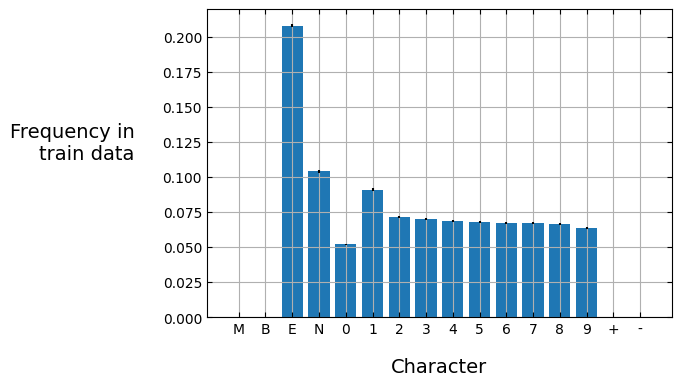

In [7]:
##=========================================================##
##   Quickly visualise distribution of token frequencies   ##
##=========================================================##

##  Imports
import numpy as np
from matplotlib import pyplot as plt

##  Get sample of train data labels
train_data_sample = np.concatenate([train_gen[i][1].numpy().flatten() for i in range(1000)])

##  Ignore masked tokens
train_data_sample = train_data_sample[train_data_sample != 0]

##  Count number for each token
chars, freqs = [], []
for token, char in train_gen.token_transform.detokeniser_dict.items() :
    chars.append(char)
    freqs.append(len(train_data_sample[train_data_sample==token]))
    
##  Normalise counts to frequency
freqs     = np.array(freqs).astype(np.float32)
freqs_err = np.sqrt(freqs)
freqs_tot = np.sum(freqs)
freqs     /= freqs_tot
freqs_err /= freqs_tot

##  Log token frequencies
for char, freq, freq_err in zip(chars, freqs, freqs_err) :
    logger.debug(f"Token '{char}' in training data with frequency {100.*freq:.1f} +- {100.*freq_err:.1f} % (masked)")

##  Plot quick bar chart of frequencies
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", axis="both", right=True, top=True, labelsize=10, direction="in")
ax.grid()
ax.set_xlabel("Character", fontsize=14, va="top"  , labelpad=15)
ax.set_ylabel("Frequency in\ntrain data", fontsize=14, ha="right", rotation=0, labelpad=20)

ax.bar(chars, freqs, yerr=freqs_err)

fig_fname = f"{working_dir}/token_distribution.pdf"
logger.info(f"Saving distribution of token frequencies to file {fig_fname}")

plt.savefig(fig_fname, bbox_inches="tight")
plt.show(fig)
plt.close(fig)


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [8]:

from tensorflow.keras.layers     import Add, Average, Concatenate, Embedding, Input, LayerNormalization
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam

from mathsformer.tf_objects import (DecoderBlock, EncoderBlock, Enumerate, FeedForwardBlock, LearnableMixture, MaskedCategoricalAccuracy,
                                    MaskedSparseCategoricalCrossentropy, PositionalEncoding)
from mathsformer.tf_objects import scalar_masked_sparse_categorical_crossentropy, scalar_masked_categorical_accuracy


In [9]:

def create_text_to_text_model(vocab_length:int, 
                              name:str, 
                              do_compile:bool       = True,
                              use_old_loss:bool     = False,
                              dtype_in              = tf.int32, 
                              dtype                 = tf.float32, 
                              dropout:float         = 0.1, 
                              jit_compile:bool      = None,
                              optimizer             = Adam,
                              optimizer_args:dict   = None,
                              idempotent_size:int   = -1,
                              pos_enc_num_freqs:int = 32, pos_enc_min_period:float = 4, pos_enc_max_period:float = 500 , pos_enc_learnable:bool = False,
                              ndim_embedding:int          = 64, comb_type:str                  = "average",
                              num_preencoder_blocks:int   = 5 , ndim_preencoder:int            = 64 , skip_connect_preencoder:bool  = True, mixture_skip_connect_preencoder:bool = False,
                              num_encoder_blocks:int      = 5 , ndim_encoder:int               = 64 , skip_connect_encoder:bool     = True, mixture_skip_connect_encoder:bool    = False,
                              num_decoder_blocks:int      = 5 , ndim_decoder:int               = 64 , skip_connect_decoder:bool     = True, mixture_skip_connect_decoder:bool    = False,
                              num_heads_preencoder:int    = 8 , ndim_att_hidden_preencoder:int = 128, ndim_ff_hidden_preencoder:int = 128, 
                              num_heads_encoder:int       = 8 , ndim_att_hidden_encoder:int    = 128, ndim_ff_hidden_encoder:int    = 128, 
                              num_heads_decoder:int       = 8 , ndim_att_hidden_decoder:int    = 128, ndim_ff_hidden_decoder:int    = 128, 
                              num_preencoder_loops:int    = 1 , num_encoder_loops:int          = 1  , num_decoder_loops:int         = 1  ,
                              num_post_layers_decoder:int = 3 , ndim_post_layers_decoder:int   = 512, 
                             ) :
    """
    """
    ##  Resolve mutable default args
    if optimizer_args is None :
        optimizer_args = {'learning_rate': 1e-3}
    
    ##=============================================##
    ##===   Input layer - Output shape [B, S]   ===##
    ##=============================================##
    x_in_enc = Input((None,), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,), dtype=dtype_in, name=f"{name}_decoder_input_layer")
            
    ##===========================================================================##
    ##===  Token embedding, masking 0s - Output shape [B, S, ndim_embedding]  ===##
    ##===========================================================================##
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_in_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_in_dec)
    
    ##=========================================================================##
    ##===  Enumerate indices for positional encoding - Output shape [B, S]  ===##
    ##=========================================================================##
    x_pos_enc = Enumerate(name=f"{name}_encoder_enumerate", dtype=dtype)(x_in_enc, minimal_dims=False)
    x_pos_dec = Enumerate(name=f"{name}_decoder_enumerate", dtype=dtype)(x_in_dec, minimal_dims=False)
    
    ##========================================================================##
    ##===  Positional encoding - Output shape [B, S, 2*pos_enc_num_freqs]  ===##
    ##========================================================================##
    x_pos_enc = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_encoder_position_encoding")(x_pos_enc)
    x_pos_dec = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_decoder_position_encoding")(x_pos_dec)

    ##==============================================================================================##
    ##===  Combine embeddings end pos enc - Output shape [B, S, N] where N depends on comb_type  ===##
    ##==============================================================================================##
    allowed_comb_types = ["add", "sum", "average", "mean", "concat", "concatenate", "mixture"]
    match comb_type.lower() :
        case "add" | "sum" :
            x_enc = Add(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Add(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "average" | "mean" :
            x_enc = Average(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Average(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "concat" | "concatenate" :
            x_enc = Concatenate(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Concatenate(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "mixture" :
            x_enc = LearnableMixture(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = LearnableMixture(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case _ :
            raise RuntimeError(f"comb_type '{comb_type}' not recognised, recognised keywords are {allowed_comb_types}")
    
    ##===================================================================##
    ##===  Pre-encoder blocks - Output shape [B, S, ndim_preencoder]  ===##
    ##===================================================================##
    preencoder_blocks = []
    for layer_idx in range(num_preencoder_blocks) :
        preencoder_blocks.append(EncoderBlock(
                                 ndim_preencoder, 
                                 num_heads_preencoder, 
                                 ndim_att_hidden_preencoder, 
                                 ndim_ff_hidden_preencoder, 
                                 dropout_mha          = dropout, 
                                 dtype                = dtype, 
                                 pre_layer_norm       = True, 
                                 post_layer_norm      = False, 
                                 skip_connect         = skip_connect_preencoder, 
                                 mixture_skip_connect = mixture_skip_connect_preencoder, 
                                 name                 = f"{name}_preencoder_block_{layer_idx+1}"))
    
    ##============================================================##
    ##===  Encoder blocks - Output shape [B, S, ndim_encoder]  ===##
    ##============================================================##
    encoder_blocks = []
    for layer_idx in range(num_encoder_blocks) :
        encoder_blocks.append(EncoderBlock(
                                 ndim_encoder, 
                                 num_heads_encoder, 
                                 ndim_att_hidden_encoder, 
                                 ndim_ff_hidden_encoder, 
                                 dropout_mha          = dropout, 
                                 dtype                = dtype, 
                                 pre_layer_norm       = True, 
                                 post_layer_norm      = False, 
                                 skip_connect         = skip_connect_encoder, 
                                 mixture_skip_connect = mixture_skip_connect_encoder, 
                                 name                 = f"{name}_encoder_block_{layer_idx+1}"))
        
    for loop_idx in range(num_encoder_loops) :
        for encoder_block in encoder_blocks :
            x_enc = encoder_block(x_enc)
    x_enc_list = [x_enc] 
    ## Previously [LayerNormalization(name=f"{name}_encoder_output_norm")(x_enc)] but post-LN now irrelevant
           
    for loop_idx in range(idempotent_size) :
        for encoder_block in encoder_blocks :
            x_enc = encoder_block(x_enc)
        x_enc_list.append(x_enc)
    
    ##============================================================##
    ##===  Decoder blocks - Output shape [B, S, ndim_decoder]  ===##
    ##============================================================##
    decoder_blocks = []
    for layer_idx in range(num_decoder_blocks) :
        decoder_blocks.append(DecoderBlock(
                                 ndim_decoder, 
                                 num_heads_decoder, 
                                 ndim_att_hidden_decoder, 
                                 ndim_ff_hidden_decoder, 
                                 dropout_mha          = dropout, 
                                 dtype                = dtype, 
                                 pre_layer_norm       = True, 
                                 post_layer_norm      = False, 
                                 skip_connect         = skip_connect_decoder, 
                                 mixture_skip_connect = mixture_skip_connect_decoder, 
                                 name                 = f"{name}_decoder_block_{layer_idx+1}"))
        
    x_dec_list = []
    for x_enc_this in x_enc_list :
        x_dec_this = x_dec
        for loop_idx in range(num_decoder_loops) :
            for decoder_block in decoder_blocks :
                x_dec_this = decoder_block([x_dec_this, x_enc_this])
        x_dec_list.append(x_dec_this)
        
    ##==================================================================================================##
    ##===  Predict logit probabilities using feed-forward block - Output shape [B, S, vocab_length]  ===##
    ##==================================================================================================##
    ##  - use layer_norm instead of batch_norm because elements in sequence are not independent
    ff_block = FeedForwardBlock(vocab_length, 
                         ndim_hidden       = ndim_post_layers_decoder, 
                         num_hidden_layers = num_post_layers_decoder, 
                         skip_connect      = False, 
                         pre_layer_norm    = True, 
                         post_layer_norm   = False, 
                         batch_norm        = False, 
                         dtype             = dtype, 
                         name              = f"{name}_output")
    x_out = [ff_block(x) for x in x_dec_list]
    
    ##  Create model
    model = Model([x_in_enc, x_in_dec], x_out if len(x_out)>1 else x_out[0], name=name)
    
    ##  Compile model with sparse categorical crossentropy loss and accuracy metric
    if do_compile :
        acc  = MaskedCategoricalAccuracy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0)
        loss = MaskedSparseCategoricalCrossentropy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0, from_logits=True)
        model.compile(loss        = loss, 
                      optimizer   = optimizer(**optimizer_args), 
                      metrics     = [acc],
                      jit_compile = jit_compile)
    
    ##  Return model
    return model


In [10]:
def create_text_to_text_model_from_config(cfg_model, token_transform) :
    """
    Create a text-to-text transformer model
    
    Inputs:
    
        >  cfg_model, Config
           Model configuration
           
        >  token_transform, TokenTransform
           Tokeniser
    """
    return create_text_to_text_model(
                          vocab_length                    = token_transform.vocab_length, 
                          name                            = cfg_model["name"],
                          do_compile                      = True,
                          use_old_loss                    = cfg_model["use_old_loss"],
                          dtype_in                        = token_transform.dtype,
                          dtype                           = cfg_model["dtype"],
                          dropout                         = cfg_model["dropout"],
                          jit_compile                     = cfg_model["jit_compile"],
                          optimizer                       = cfg_model.get("optimizer", Adam),
                          optimizer_args                  = cfg_model.get("optimizer_args", {}),
                          idempotent_size                 = cfg_model["idempotent_size"],
                          pos_enc_num_freqs               = cfg_model["positional_encoding"]["num_freqs"],
                          pos_enc_min_period              = cfg_model["positional_encoding"]["min_period"],
                          pos_enc_max_period              = cfg_model["positional_encoding"]["max_period"],
                          pos_enc_learnable               = cfg_model["positional_encoding"]["learnable"],
                          ndim_embedding                  = cfg_model["ndim_embedding"],
                          num_preencoder_blocks           = cfg_model["pre_encoder"]["num_blocks"],
                          num_preencoder_loops            = cfg_model["pre_encoder"]["num_loops"],
                          ndim_preencoder                 = cfg_model["pre_encoder"]["ndim"],
                          num_heads_preencoder            = cfg_model["pre_encoder"]["num_heads"],
                          ndim_att_hidden_preencoder      = cfg_model["pre_encoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_preencoder       = cfg_model["pre_encoder"]["ndim_ff_hidden"],
                          skip_connect_preencoder         = cfg_model["pre_encoder"]["skip_connect"],
                          mixture_skip_connect_preencoder = cfg_model["pre_encoder"]["mixture_skip_connect"],
                          num_encoder_blocks              = cfg_model["encoder"]["num_blocks"],
                          num_encoder_loops               = cfg_model["encoder"]["num_loops"],
                          ndim_encoder                    = cfg_model["encoder"]["ndim"],
                          num_heads_encoder               = cfg_model["encoder"]["num_heads"],
                          ndim_att_hidden_encoder         = cfg_model["encoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_encoder          = cfg_model["encoder"]["ndim_ff_hidden"],
                          skip_connect_encoder            = cfg_model["encoder"]["skip_connect"],
                          mixture_skip_connect_encoder    = cfg_model["encoder"]["mixture_skip_connect"],
                          num_decoder_blocks              = cfg_model["decoder"]["num_blocks"],
                          num_decoder_loops               = cfg_model["decoder"]["num_loops"],
                          ndim_decoder                    = cfg_model["decoder"]["ndim"],
                          num_heads_decoder               = cfg_model["decoder"]["num_heads"],
                          ndim_att_hidden_decoder         = cfg_model["decoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_decoder          = cfg_model["decoder"]["ndim_ff_hidden"],
                          skip_connect_decoder            = cfg_model["decoder"]["skip_connect"],
                          mixture_skip_connect_decoder    = cfg_model["decoder"]["mixture_skip_connect"],
                          num_post_layers_decoder         = cfg_model["post_decoder"]["num_layers"],
                          ndim_post_layers_decoder        = cfg_model["post_decoder"]["ndim"],)


In [11]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
    model.optimizer.learning_rate.assign(cfg_model["optimizer_args"]["learning_rate"])  ## Reset LR to config value
else :
    logger.info(f"Creating new text-to-text model")
    model = create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)
    
##  Print optimizer summary
logger.info(f"Optimizer is {model.optimizer}")
if hasattr(model.optimizer, "learning_rate") : logger.info(f"Learning rate is {model.optimizer.learning_rate}")
if hasattr(model.optimizer, "weight_decay" ) : logger.info(f"Weight decay is {model.optimizer.weight_decay}")


   INFO <module>: Creating new text-to-text model


   INFO <module>: Model created with summary:


INFO:mathsformer:Model created with summary:


   INFO <module>: Model: "mathsformer_LLM"


INFO:mathsformer:Model: "mathsformer_LLM"


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     


INFO:mathsformer: Layer (type)                   Output Shape         Param #     Connected to                     


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 160)   2560        ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_embedd  (None, None, 160)   2560        ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_positi  (None, None, 160)   80          ['mathsformer_LLM_encoder_enumera


INFO:mathsformer: mathsformer_LLM_encoder_positi  (None, None, 160)   80          ['mathsformer_LLM_encoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_emb_an  (None, None, 160)   0           ['mathsformer_LLM_encoder_embeddi


INFO:mathsformer: mathsformer_LLM_encoder_emb_an  (None, None, 160)   0           ['mathsformer_LLM_encoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_encoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 160)   1080804     ['mathsformer_LLM_encoder_emb_and


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 160)   1080804     ['mathsformer_LLM_encoder_emb_and


   INFO <module>:  1 (EncoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (EncoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [0][0]',                         


INFO:mathsformer:                                                                 [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [8][0]']                         


INFO:mathsformer:                                                                 [8][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 160)   1080804     ['mathsformer_LLM_encoder_block_1


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 160)   1080804     ['mathsformer_LLM_encoder_block_1


   INFO <module>:  2 (EncoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (EncoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [8][0]',                         


INFO:mathsformer:                                                                 [8][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [9][0]']                         


INFO:mathsformer:                                                                 [9][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_embedd  (None, None, 160)   2560        ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_embedd  (None, None, 160)   2560        ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_positi  (None, None, 160)   80          ['mathsformer_LLM_decoder_enumera


INFO:mathsformer: mathsformer_LLM_decoder_positi  (None, None, 160)   80          ['mathsformer_LLM_decoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_emb_an  (None, None, 160)   0           ['mathsformer_LLM_decoder_embeddi


INFO:mathsformer: mathsformer_LLM_decoder_emb_an  (None, None, 160)   0           ['mathsformer_LLM_decoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_decoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 160)   1904326     ['mathsformer_LLM_decoder_emb_and


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 160)   1904326     ['mathsformer_LLM_decoder_emb_and


   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (DecoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [8][0]',                         


INFO:mathsformer:                                                                 [8][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [9][0]']                         


INFO:mathsformer:                                                                 [9][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 160)   1904326     ['mathsformer_LLM_decoder_block_1


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 160)   1904326     ['mathsformer_LLM_decoder_block_1


   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (DecoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [8][0]',                         


INFO:mathsformer:                                                                 [8][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [9][0]']                         


INFO:mathsformer:                                                                 [9][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_output (FeedFo  (None, None, 16)    1423536     ['mathsformer_LLM_decoder_block_2


INFO:mathsformer: mathsformer_LLM_output (FeedFo  (None, None, 16)    1423536     ['mathsformer_LLM_decoder_block_2


   INFO <module>:  rwardBlock)                                                     [0][0]',                         


INFO:mathsformer: rwardBlock)                                                     [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [2][0]']                         


INFO:mathsformer:                                                                 [2][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>: Total params: 7,399,076


INFO:mathsformer:Total params: 7,399,076


   INFO <module>: Trainable params: 7,399,076


INFO:mathsformer:Trainable params: 7,399,076


   INFO <module>: Non-trainable params: 0


INFO:mathsformer:Non-trainable params: 0


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>: Optimizer is <keras.optimizers.adamw.AdamW object at 0x2888d10d0>


INFO:mathsformer:Optimizer is <keras.optimizers.adamw.AdamW object at 0x2888d10d0>


   INFO <module>: Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


INFO:mathsformer:Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


   INFO <module>: Weight decay is 0.02


INFO:mathsformer:Weight decay is 0.02


In [12]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [13]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen, negative_char=negative_char)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:


   INFO print_predictions_table: --------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------


   INFO print_predictions_table:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: --------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------


   INFO print_predictions_table:  N7724-8+N615-687-678        N9712      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N7724-8+N615-687-678        N9712      --EEE55          --5                      ?   


   INFO print_predictions_table:            N557+N3170        N3727      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:           N557+N3170        N3727      --EEE55          --5                      ?   


   INFO print_predictions_table:                     7            7      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                    7            7      --5EE55          --5                      ?   


   INFO print_predictions_table:      N3+6+9469+N9+475         9938      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N3+6+9469+N9+475         9938      --EEE55          --5                      ?   


   INFO print_predictions_table:                 N7403        N7403      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                N7403        N7403      --5EE55          --5                      ?   


   INFO print_predictions_table:   N2336-N15-700+N6219        N9240      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N2336-N15-700+N6219        N9240      --EEE55          --5                      ?   


   INFO print_predictions_table:   629+N815+308+N2-763         N643      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  629+N815+308+N2-763         N643      --EEE55          --5                      ?   


   INFO print_predictions_table:         9+34-N65+N223         N115      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:        9+34-N65+N223         N115      --5EE55          --5                      ?   


   INFO print_predictions_table:   N3517-6312+N4-N2561        N7272      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N3517-6312+N4-N2561        N7272      --5EE55          --5                      ?   


   INFO print_predictions_table:           4-N2+6413+7         6426      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          4-N2+6413+7         6426      --5EE55          --5                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some validation data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some validation data:


   INFO print_predictions_table: --------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------------


   INFO print_predictions_table:                       INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                      INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: --------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------------


   INFO print_predictions_table:                  5-N276-639         N358      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                 5-N276-639         N358      --EEE55          --5                      ?   


   INFO print_predictions_table:    789+N24-N281+3095-N4+726         4871      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   789+N24-N281+3095-N4+726         4871      --5EE55          --5                      ?   


   INFO print_predictions_table:               298-8445+N663        N8810      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:              298-8445+N663        N8810      --5EE55          --5                      ?   


   INFO print_predictions_table:  9+4-N8055-N302+N4928-N8672        12114      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 9+4-N8055-N302+N4928-N8672        12114      --EEE55          --5                      ?   


   INFO print_predictions_table:               N948-5139+N10        N6097      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:              N948-5139+N10        N6097      --EEE55          --5                      ?   


   INFO print_predictions_table:              N47+N935-N9554         8572      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N47+N935-N9554         8572      --5EE55          --5                      ?   


   INFO print_predictions_table:                     89+4-55           38      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                    89+4-55           38      --5EE55          --5                      ?   


   INFO print_predictions_table:                 N93-649+396         N346      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                N93-649+396         N346      --EEE55          --5                      ?   


   INFO print_predictions_table:                N62+N291+259          N94      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:               N62+N291+259          N94      --EEE55          --5                      ?   


   INFO print_predictions_table:                 9405-3+N447         8955      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                9405-3+N447         8955      --EEE55          --5                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some test data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some test data:


   INFO print_predictions_table: ------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------------


   INFO print_predictions_table:                           INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                          INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------------


   INFO print_predictions_table:   N36+3544+9096+1-N3995-216+N40        16344      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N36+3544+9096+1-N3995-216+N40        16344      --EEE55          --5                      ?   


   INFO print_predictions_table:      37+N6502+N99-N5+N7-5228+N8       N11802      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     37+N6502+N99-N5+N7-5228+N8       N11802      --5EE55          --5                      ?   


   INFO print_predictions_table:  N30-788-N965+N35-N255-9962-...        N3719      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N30-788-N965+N35-N255-9962-...        N3719      --5EE55          --5                      ?   


   INFO print_predictions_table:  N5-N5847+N64-N850+N87-348+N...         5157      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N5-N5847+N64-N850+N87-348+N...         5157      --5EE55          --5                      ?   


   INFO print_predictions_table:  3763-N40+N600-65+7099+55-N2...        10995      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 3763-N40+N600-65+7099+55-N2...        10995      --EEE55          --5                      ?   


   INFO print_predictions_table:   N9-2463+1333+4949+599+N5+N806         3598      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N9-2463+1333+4949+599+N5+N806         3598      --5EE55          --5                      ?   


   INFO print_predictions_table:         928+9-779+832+N6+7963-7         8940      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:        928+9-779+832+N6+7963-7         8940      --EEE55          --5                      ?   


   INFO print_predictions_table:            481-22+N95-8-7+N7+19          361      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:           481-22+N95-8-7+N7+19          361      --EEE55          --5                      ?   


   INFO print_predictions_table:  N690-N5068+N29-N5703-N95-N7...        10905      --EEE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N690-N5068+N29-N5703-N95-N7...        10905      --EEE55          --5                      ?   


   INFO print_predictions_table:  27+3-N584-N57+272-N21-N1771...         4359      --5EE55          --5                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 27+3-N584-N57+272-N21-N1771...         4359      --5EE55          --5                      ?   


##  5.  Train model

In [14]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, 
                                  val_gen=val_gen, negative_char=negative_char)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LoggerCallback with loglvl=10


   INFO get_callbacks: Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


   INFO get_callbacks: Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed160_enc_2blocks_8loops_width800_dec_2blocks_1loops_width800_post3_width800_idem2_2023_06_28/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed160_enc_2blocks_8loops_width800_dec_2blocks_1loops_width800_post3_width800_idem2_2023_06_28/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


   INFO get_callbacks: Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


In [15]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000


INFO:mathsformer:Begin model training with max_epochs=100000
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Setting variable to learning_rate:0


Epoch 1/100000


2023-06-28 18:51:59.645467: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 156/2000 [=>............................] - ETA: 28:04 - loss: 6.1129 - mathsformer_LLM_output_loss: 2.0383 - mathsformer_LLM_output_1_loss: 2.0365 - mathsformer_LLM_output_2_loss: 2.0382 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3422 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3424 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3426

KeyboardInterrupt: 

In [ ]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.keras"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


## 6.  Evaluate model

In [ ]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print, 
                         negative_char=negative_char)


##  7. Additional visualisations

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

In [ ]:
##===============================##
##   Visualise training curves   ##
##===============================##

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    